## Decision Tree и KNN

In [1]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, cross_val_score, learning_curve,
                                     StratifiedKFold, validation_curve, RandomizedSearchCV)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve
from tqdm import tqdm

In [2]:
# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

# настройка стиля графиков
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# читаем данные
df = pd.read_csv('./data/telecom_churn.csv')

# выведу для проверки
df.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Подготовка данных

In [4]:
# OHE для International plan и Voice mail plan

df = pd.get_dummies(df, columns=['International plan', 'Voice mail plan'])
df

,State,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,...,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,International plan_No,International plan_Yes,Voice mail plan_No,Voice mail plan_Yes
0,KS,128,415,25,265.1,110,45.07,197.4,99,16.78,...,11.01,10.0,3,2.70,1,False,1,0,0,1
1,OH,107,415,26,161.6,123,27.47,195.5,103,16.62,...,11.45,13.7,3,3.70,1,False,1,0,0,1
2,NJ,137,415,0,243.4,114,41.38,121.2,110,10.30,...,7.32,12.2,5,3.29,0,False,1,0,1,0
3,OH,84,408,0,299.4,71,50.90,61.9,88,5.26,...,8.86,6.6,7,1.78,2,False,0,1,1,0
4,OK,75,415,0,166.7,113,28.34,148.3,122,12.61,...,8.41,10.1,3,2.73,3,False,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,36,156.2,77,26.55,215.5,126,18.32,...,12.56,9.9,6,2.67,2,False,1,0,0,1
3329,WV,68,415,0,231.1,57,39.29,153.4,55,13.04,...,8.61,9.6,4,2.59,3,False,1,0,1,0
3330,RI,28,510,0,180.8,109,30.74,288.8,58,24.55,...,8.64,14.1,6,3.81,2,False,1,0,1,0
3331,CT,184,510,0,213.8,105,36.35,159.6,84,13.57,...,6.26,5.0,10,1.35,2,False,0,1,1,0


In [5]:
# отделю таргет и признаки
X = df.drop('Churn', axis=1)
y = df['Churn']

# воспроизводимость
rs = np.random.seed(0)
    
# разобью данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rs, stratify=y)
       
print('Доля оттока в трейне: {:.4f}'.format(np.mean(y_train)), end='\n\n')
print('Доля оттока в тесте: {:.4f}'.format(np.mean(y_test)))

Доля оттока в трейне: 0.1449

Доля оттока в тесте: 0.1450


Тк выборка не сбалансирована, оценивать буду по ROC-AUC.

In [6]:
# закодирую категориальные переменные

label_encoder = LabelEncoder()

for column in X_train.columns[X_train.dtypes == 'object']:
    X_train[column] = label_encoder.fit_transform(X_train[column])
    X_test[column] = label_encoder.transform(X_test[column])

In [7]:
# стандартизация данных

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Построение моделей

In [8]:
def cross_validation(classifier, X_train, y_train, cv=3, scoring='accuracy'):
    # название модели для красивого вывода
    clf_name = str(classifier)
    clf_name = clf_name[:clf_name.index('(')]
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv)
    print('Среднее значение \033[1m{}\033[0m для {} на валидации: \033[1m{:.4f}\033[0m'.format(
        scoring, clf_name, np.mean(cv_scores)))
    
def fit_evaluate(classifier, X_train, X_test, y_train, y_test, metric=accuracy_score):
    # название модели для красивого вывода
    clf_name = str(classifier)
    clf_name = clf_name[:clf_name.index('(')]
    
    # название метрики 
    metric_name = str(metric)
    metric_name = metric_name[metric_name.index(' ')+1:metric_name.index(' at')]
    classifier.fit(X_train, y_train)
    predictions = classifier.predict_proba(X_test)[:, 1]
    print('Среднее значение \033[1m{}\033[0m для {} на отложенной выборке: \033[1m{:.4f}\033[0m'.format(
        metric_name, clf_name, metric(y_test, predictions)))

In [9]:
# дерево решений
dt = DecisionTreeClassifier(random_state=rs)

cross_validation(dt, X_train, y_train, cv=5, scoring='roc_auc')
fit_evaluate(dt, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для DecisionTreeClassifier на валидации: 0.8218
Среднее значение roc_auc_score для DecisionTreeClassifier на отложенной выборке: 0.8765


In [10]:
# KNN
knn = KNeighborsClassifier()

cross_validation(knn, X_train, y_train, cv=5, scoring='roc_auc')
fit_evaluate(knn, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для KNeighborsClassifier на валидации: 0.8094
Среднее значение roc_auc_score для KNeighborsClassifier на отложенной выборке: 0.8207


Дерево решений существенно лучше на отложенной выборке.

## Подбор гиперпараметров для дерева решений

In [11]:
# кросс валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

tree_params = dict(splitter=['best', 'random'],
                 max_depth=np.arange(1, 100),
                 max_features=np.arange(0, 1, 0.05)
                )

tree_cv = RandomizedSearchCV(estimator=dt, param_distributions=tree_params,
                             cv=skf, n_jobs=-1,random_state=rs, n_iter=1000)

tree_cv.fit(X_train, y_train)
best_tree = tree_cv.best_estimator_

preds = best_tree.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, preds)
print(f'ROC-AUC для DT {score:.4f}', end='\n\n')
print(classification_report(y_test, np.where(preds>0.5, 1, 0)))

ROC-AUC для DT 0.8829

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       855
        True       0.87      0.81      0.84       145

    accuracy                           0.95      1000
   macro avg       0.92      0.90      0.91      1000
weighted avg       0.95      0.95      0.95      1000



## Подбор гиперпараметров для KNN

In [12]:
knn_params = dict(weights=['uniform', 'distance'],
                 n_neighbors=np.arange(1, 100),
                 leaf_size=np.arange(2, 100)
                )

knn_cv = RandomizedSearchCV(estimator=knn, param_distributions=knn_params,
                             cv=skf, n_jobs=-1,random_state=rs, n_iter=1000)

knn_cv.fit(X_train, y_train)
best_knn = knn_cv.best_estimator_

preds = best_knn.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, preds)

print(f'ROC-AUC для KNN {score:.4f}', end='\n\n')
print(classification_report(y_test, np.where(preds>0.5, 1, 0)))

ROC-AUC для KNN 0.8207

              precision    recall  f1-score   support

       False       0.90      0.98      0.94       855
        True       0.74      0.34      0.46       145

    accuracy                           0.89      1000
   macro avg       0.82      0.66      0.70      1000
weighted avg       0.87      0.89      0.87      1000



Дерево решений заметно лучше.

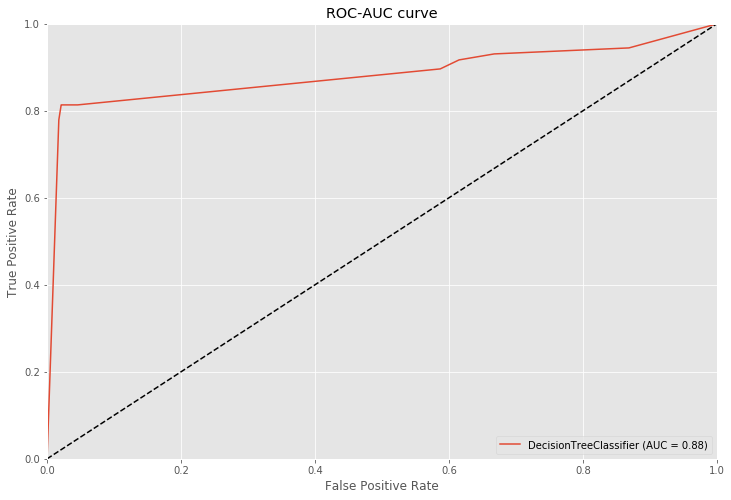

In [13]:
# roc кривая для DT

plot_roc_curve(best_tree, X_test, y_test)
plt.title('ROC-AUC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Кривые обучения и валидации

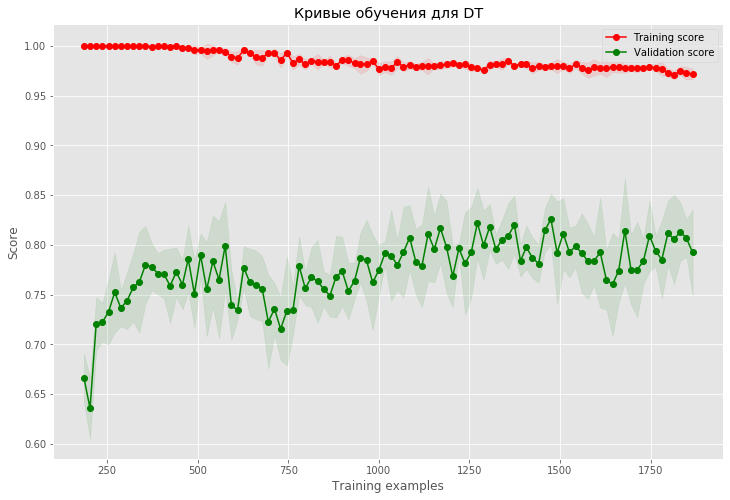

In [14]:
# построю кривые обучения

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Validation score')

    plt.legend(loc="best")
    return plt


plot_learning_curve(best_tree, 'Кривые обучения для DT', X_train, y_train,
                    train_sizes=np.linspace(.1, 1.0, 100), cv=5, n_jobs=-1);

Кривые обучения выглядят адекватно.

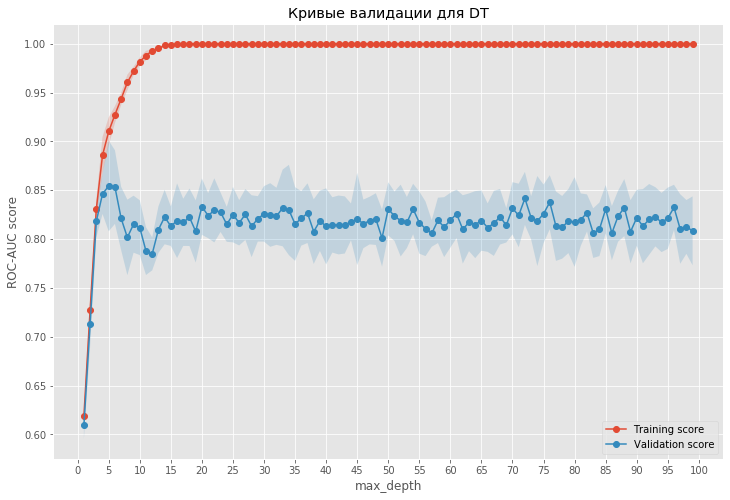

In [15]:
# построю кривые валидации

def plot_with_err(param, data, **kwargs):
    """
    Строит кривые валидации
    """
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(param, mu, 'o-', **kwargs)
    plt.fill_between(param, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
    
max_depth = np.arange(1, 100)
val_train, val_test = validation_curve(best_tree, X_train, y_train,
                                       'max_depth', max_depth, cv=5,
                                        scoring='roc_auc', n_jobs=-1)


plot_with_err(max_depth, val_train, label='Training score')
plot_with_err(max_depth, val_test, label='Validation score')
plt.xlabel('max_depth'); plt.ylabel('ROC-AUC score')
plt.xticks(max_depth)
plt.xticks(np.arange(0, 105, 5))
plt.title('Кривые валидации для DT')
plt.legend();

Видно, что на тренировочных данных дерево решений довольно быстро подгонится под выборку, уже при глубине дерева 15.  

In [16]:
print(best_tree)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=0.7000000000000001,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')


## Отбор признаков

Реализую отбор признаков простым перебором.

In [17]:
def feature_selector(estimator, X, y, cv=3, scoring='accuracy'):
    """
    Simple feature selector
    :param estimator: sklearn like eatimator
    :param X: features, pandas DataFrame
    :param y: labels, pandas Series
    """
    # формируем список признаков
    features = list(X.columns)
    
    # сохраняем результат на всех фичах
    best_score = np.mean(cross_val_score(estimator, X, y, cv=cv, scoring=scoring))
    best_features = features.copy()
    
    for column in tqdm(features):
        if column in best_features:
            best_features.remove(column)
            score = np.mean(cross_val_score(estimator, X[best_features], y, cv=cv, scoring=scoring))
            # если результат ухудшился, возвращаем признак в список
            if score < best_score:
                best_features.append(column)
            else:
                best_score = score
    print(f'Best validation score is {best_score:.4f}')
    
    # обучаем классификатор на полученных фичах
    estimator.fit(X[best_features], y)
    
    return estimator, best_features

In [18]:
# приведем признаки обратно к пандас для удобства работы с признаками
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

final_tree, best_features = feature_selector(best_tree, X_train, y_train, cv=skf, scoring='roc_auc')

predictions = final_tree.predict_proba(X_test[best_features])[:, 1]
print(f'Final ROC-AUC is {roc_auc_score(y_test, predictions):.4f}')

100%|██████████| 21/21 [00:02<00:00, 10.17it/s]

Best validation score is 0.8187
Final ROC-AUC is 0.8854


Отбор признаков позволил улучшить результат модели.